# Hashtag coocurrences
I want to see which hashtags typically occur together with other hashtags, but only for the most important hashtags we identified previously. 
1. Create a subset of tweets containing the important hashtags and discard the rest:
- These are the important hashtags from tweets captured prior to 01/08/2021
    - #knifecrime
    - #crime
    - #stopandsearch
    - #police
    - #charliehebdo
    - #speakerscorner
    - #beatingcrimeplan
    - #policecuts
    - #austerity
    - #stabbing
2. Create a network of hashtags and their co-occurances
    - create a node for each hashtag
    - create an edge between hashtags to show they're related
    - give each edge a weight to show how statistically significant it is


## Revisit once we have all data from 4 weeks
- because we have a fraction of tweets containing hashtag that Bovet had
- and update hash

In [62]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
all_tweets = pd.read_csv("./DataSources/TwitterData/cleaned_tweets.csv")
print(all_tweets.shape)
all_tweets.head()

(14687, 25)


,index,tweet_id,tweet_date,tweeter_id,tweeter_user_name,tweeter_screen_name,tweeter_location,message_text,in_reply_to_user_screen_name,quote_tweet_screen_name,...,mentioned,hashtags,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_lemmatized,Clean_MessageText,tweet_date_dt,time_bins_12h,day_bins
0,0,1420355029081395203,2021-07-28 12:06:42,865262041103302656,Chris Myers,myerschrismyer1,Richmond North Yorkshire,RT @LeslieH24367191: 'Do better!' Boris Johnso...,NaN,NaN,...,[],[],Do better Boris Johnson issues scathing respo...,"['do', 'better', 'boris', 'johnson', 'issues',...","['better', 'boris', 'johnson', 'issues', 'scat...","['good', 'boris', 'johnson', 'issues', 'scathi...",good boris johnson issues scathing response sa...,2021-07-28 12:06:42,2021-07-28 12:00:00,28
1,1,1420354120041615364,2021-07-28 12:03:05,229645453,Emily Sheffield,emilysheffield,London,RT @NaheedMajeed: Spot on @standardnews With L...,NaN,NaN,...,['@standardnews'],[],Spot on With London on track to break record...,"['spot', 'on', 'with', 'london', 'on', 'track'...","['spot', 'track', 'break', 'record', 'teenage'...","['spot', 'track', 'break', 'record', 'teenage'...",spot track break record teenage murdersstop se...,2021-07-28 12:03:05,2021-07-28 12:00:00,28
2,2,1420351785156366337,2021-07-28 11:53:49,2843896642,Basilewitch,basilewitch,France,RT @Short2Cjs: Boris today speaking to Nick Fe...,NaN,NaN,...,[],[],Boris today speaking to Nick Ferrari about Kh...,"['boris', 'today', 'speaking', 'to', 'nick', '...","['boris', 'today', 'speaking', 'nick', 'ferrar...","['boris', 'today', 'speaking', 'nick', 'ferrar...",boris today speaking nick ferrari khan … done ...,2021-07-28 11:53:49,2021-07-28 00:00:00,28
3,3,1420350419449094148,2021-07-28 11:48:23,556315551,Dean Cowcher,DeanCowcher,Bexleyheath London England,RT @LeslieH24367191: 'Do better!' Boris Johnso...,NaN,NaN,...,[],[],Do better Boris Johnson issues scathing respo...,"['do', 'better', 'boris', 'johnson', 'issues',...","['better', 'boris', 'johnson', 'issues', 'scat...","['good', 'boris', 'johnson', 'issues', 'scathi...",good boris johnson issues scathing response sa...,2021-07-28 11:48:23,2021-07-28 00:00:00,28
4,4,1420349615954669574,2021-07-28 11:45:11,1267062754915090434,Alfiecat,sonya_annie,unknown,RT @Short2Cjs: Boris today speaking to Nick Fe...,NaN,NaN,...,[],[],Boris today speaking to Nick Ferrari about Kh...,"['boris', 'today', 'speaking', 'to', 'nick', '...","['boris', 'today', 'speaking', 'nick', 'ferrar...","['boris', 'today', 'speaking', 'nick', 'ferrar...",boris today speaking nick ferrari khan … done ...,2021-07-28 11:45:11,2021-07-28 00:00:00,28


##  Create a network of coocurring hashtags
- Below we have a list of hashtags we are interested in (list identified when analysing 1_7)

In [64]:
hashtag_list_20210801 = ['#knifecrime',
                '#crime',
                '#stopandsearch',
                '#police',
                '#charliehebdo',
                '#speakerscorner',
                '#beatingcrimeplan',
                '#policecuts',
                '#austerity',
                '#stabbing']

hashtag_list = hashtag_list_20210801

### For each hashtag, get its related hashtags

In [65]:
def string_to_list(my_str):
    delimiter = ","
    my_str = my_str.replace("[", "")
    my_str = my_str.replace("]", "")
    my_str = my_str.replace("'", "")
    my_str = my_str.replace(" ", "")
    my_list = my_str.split(delimiter)
    return my_list

def contains_important_hashtags(hashtags, hashtag_list):
    is_present = any(item in hashtags for item in hashtag_list)
    
    if is_present is False:
        return None    
    else :
        return hashtags
    
def getAllHashtagInteractions(tweet, hashtag_list):
    
    ret_val = contains_important_hashtags(tweet.hashtags, hashtag_list)
    
    if ret_val == None:
        return None, None
    else:
        
        interacting_hastags = set()
        
        my_hashtags = string_to_list(tweet.hashtags)
        
        first_hashtag = my_hashtags[0]
        
        for item in my_hashtags[1:]:
            interacting_hastags.add(item)
            
        # remove first hashtag if in the set
        interacting_hastags.discard(first_hashtag)
        
        return first_hashtag, list(interacting_hastags)
    

### Create our nework
- nodes are the hashtags
- edges are the links between hashtags

In [66]:
import networkx as nx

# define an empty Directed Graph
# A directed graph is a graph where edges have a direction
# in our case the edges goes from user that sent the tweet to
# the user with whom they interacted (retweeted, mentioned or quoted)
G = nx.DiGraph()

for index, tweet in all_tweets.iterrows():
    first_hashtag, interactions = getAllHashtagInteractions(tweet, hashtag_list)
    
    if first_hashtag != None:
    
        # add an edge to the Graph for each hashtag
        for other_hashtag in interactions:
        
            # add edges between the two user ids
            # this will create new nodes if the nodes are not already in the network
            # we also add an attribute the to edge equal to the id of the tweet
            G.add_edge(first_hashtag, other_hashtag, tweet_id=tweet.tweet_id)
        
            # add name as a property to each node
            # with networkX each node is a dictionary
            G.nodes[first_hashtag]['name'] = first_hashtag
            G.nodes[other_hashtag]['name'] = other_hashtag

In [67]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 97
Number of edges: 115
Average in degree:   1.1856
Average out degree:   1.1856


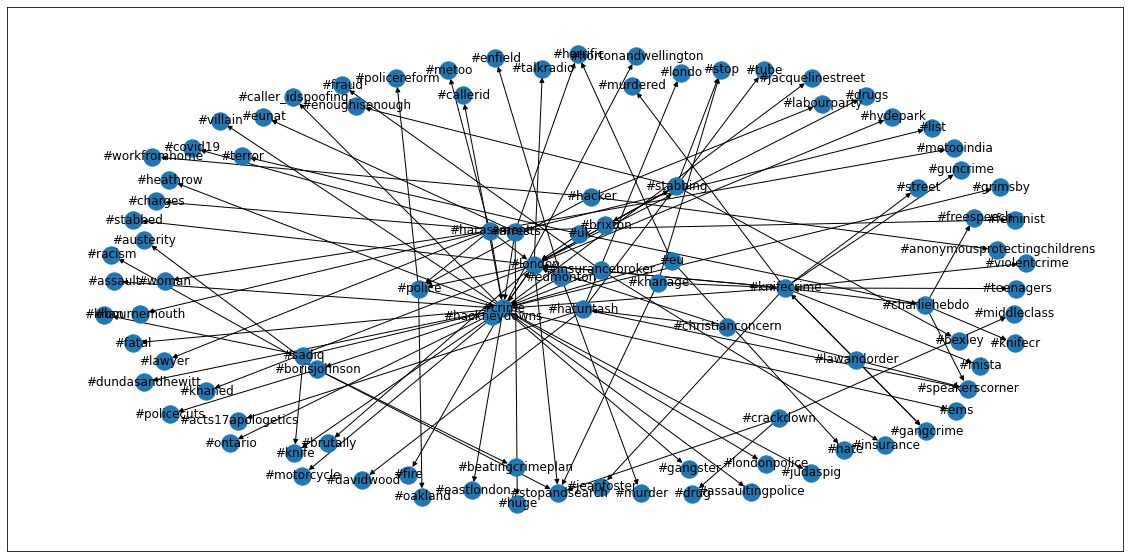

In [68]:
plt.figure(figsize=(20,10))
nx.draw_networkx(G)
plt.show()

### Now we want to test the probability of these co-occurances
We want to exclude those that could happen by chance. The first step is to assign weights to the edges based on the number of times they are traversed. The code for this was reused from https://stackoverflow.com/questions/58803155/creating-a-weighted-network-from-co-occurence-of-hashtags-from-a-dataframe

- First step is to return a list of tuples, where each tuple is a single instance of a hashtag coocurrance

In [124]:
def getAllHashtagInteractions__(tweet, hashtag_list):
    
    ret_val = None
    
    ret_val = contains_important_hashtags(tweet.hashtags, hashtag_list)
    
    if ret_val == None:
        return None
    else:
        
        interacting_hastags = set()
        
        my_hashtags = string_to_list(tweet.hashtags)
                
        for item in my_hashtags:
            interacting_hastags.add(item)
        
        return list(interacting_hastags)

def get_all_edges(interactions):    
    
    # return if just one item left in the hashtag list
    if len(interactions) < 2:
        return None
    else:
        
        hashtag_relationships = []
        first_hashtag = interactions[0]
        remaining_hashtags = interactions[1:]

        for current_hashtag in remaining_hashtags:
            hashtag_relationships.append((first_hashtag, current_hashtag))
            
        other_hashtags = get_all_edges(remaining_hashtags)
        
        if other_hashtags != None:
            hashtag_relationships.extend(other_hashtags)
        
        return hashtag_relationships

In [126]:
all_edges = []
for index, tweet in all_tweets.iterrows():
    interactions__ = getAllHashtagInteractions__(tweet, hashtag_list)
    if interactions__ != None:
        start_idx = 0
        current_edges = get_all_edges(interactions__)
        
        if current_edges != None:
            all_edges.extend(current_edges)

In [127]:
all_edges = [sorted(edge) for edge in all_edges]
all_edges[:10]

[['#hortonandwellington', '#knife'],
 ['#crime', '#hortonandwellington'],
 ['#crime', '#knife'],
 ['#khan', '#knife'],
 ['#khan', '#sadiq'],
 ['#crime', '#khan'],
 ['#knife', '#sadiq'],
 ['#crime', '#knife'],
 ['#crime', '#sadiq'],
 ['#knifecrime', '#london']]

In [128]:
# create pandas dataframe
df_edges = pd.DataFrame(all_edges, columns=['source', 'target'])
df_edges.head()

,source,target
0,#hortonandwellington,#knife
1,#crime,#hortonandwellington
2,#crime,#knife
3,#khan,#knife
4,#khan,#sadiq


In [129]:
# aggregate repeated edges
# c.f. https://stackoverflow.com/questions/10373660/converting-a-pandas-groupby-output-from-series-to-dataframe
df_edges = pd.DataFrame({'count' : df_edges.groupby(['source', 'target']).size()}).reset_index()
df_edges.head()

,source,target,count
0,#acts17apologetics,#davidwood,2
1,#acts17apologetics,#hatuntash,2
2,#acts17apologetics,#londo,1
3,#acts17apologetics,#speakerscorner,2
4,#acts17apologetics,#stabbing,2


In [132]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 97
Number of edges: 280
Average degree:   5.7732


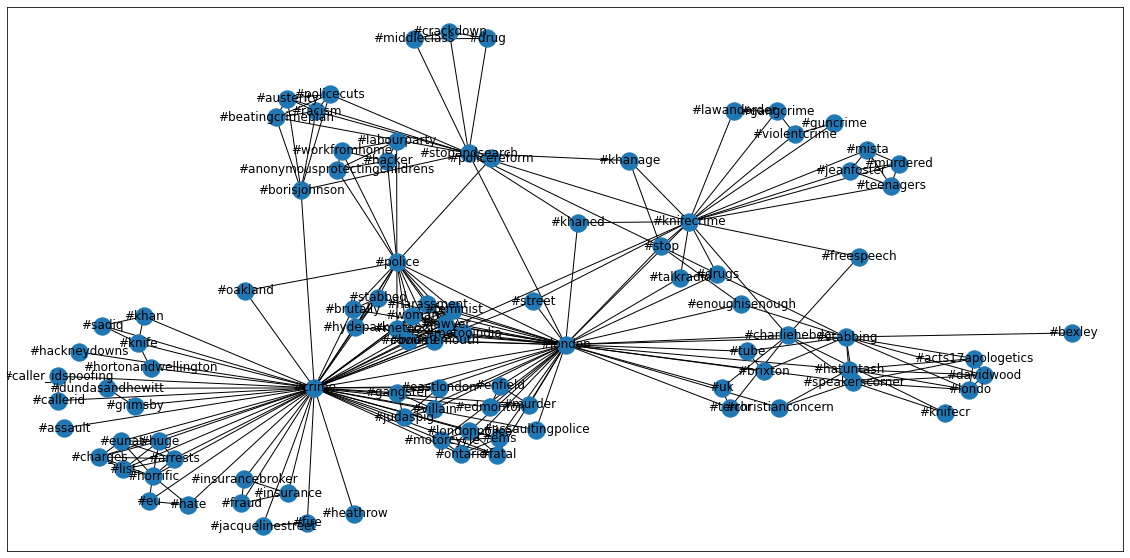

In [133]:
plt.figure(figsize=(20,10))
nx.draw_networkx(g)
plt.show()

In [131]:
for u,v,d in g.edges(data=True):
    print (u,v,d)

#acts17apologetics #davidwood {'count': 2}
#acts17apologetics #hatuntash {'count': 2}
#acts17apologetics #londo {'count': 1}
#acts17apologetics #speakerscorner {'count': 2}
#acts17apologetics #stabbing {'count': 2}
#davidwood #hatuntash {'count': 2}
#davidwood #londo {'count': 1}
#davidwood #speakerscorner {'count': 2}
#davidwood #stabbing {'count': 2}
#hatuntash #christianconcern {'count': 1}
#hatuntash #londo {'count': 1}
#hatuntash #london {'count': 1}
#hatuntash #speakerscorner {'count': 3}
#hatuntash #stabbing {'count': 2}
#londo #speakerscorner {'count': 1}
#londo #stabbing {'count': 1}
#speakerscorner #charliehebdo {'count': 10}
#speakerscorner #christianconcern {'count': 1}
#speakerscorner #knifecr {'count': 9}
#speakerscorner #london {'count': 1}
#speakerscorner #stabbing {'count': 2}
#stabbing #bexley {'count': 1}
#stabbing #brixton {'count': 2}
#stabbing #enoughisenough {'count': 1}
#stabbing #london {'count': 3}
#stabbing #stop {'count': 1}
#stabbing #tube {'count': 1}
#ano